Device: cuda
Found 3616 COVID images at /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images

Loading datasets...
TRAIN: 5216 known + 0 novel = 5216
VAL: 16 known + 0 novel = 16
TEST: 624 known + 300 novel = 924

TRAINING ATTENTIONFUZZYNET
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 185MB/s]  



PHASE 1: TRAINING FEATURE EXTRACTOR WITH CENTER LOSS


Epoch 1: Loss=2.2951, Val Acc=87.50%


Epoch 2: Loss=1.0592, Val Acc=87.50%


Epoch 3: Loss=0.6204, Val Acc=100.00%


Epoch 4: Loss=0.4395, Val Acc=93.75%


Epoch 5: Loss=0.3531, Val Acc=100.00%


Epoch 6: Loss=0.2875, Val Acc=100.00%


Epoch 7: Loss=0.2345, Val Acc=100.00%


Epoch 8: Loss=0.2001, Val Acc=100.00%


Epoch 9: Loss=0.1685, Val Acc=100.00%


Epoch 10: Loss=0.1500, Val Acc=100.00%


Epoch 11: Loss=0.1449, Val Acc=100.00%


Epoch 12: Loss=0.1380, Val Acc=100.00%


Epoch 13: Loss=0.1219, Val Acc=100.00%


Epoch 14: Loss=0.1159, Val Acc=100.00%


Epoch 15: Loss=0.1137, Val Acc=100.00%


Epoch 16: Loss=0.1179, Val Acc=93.75%


Epoch 17: Loss=0.1136, Val Acc=93.75%


Epoch 18: Loss=0.1030, Val Acc=93.75%


Epoch 19: Loss=0.0987, Val Acc=93.75%


Epoch 20: Loss=0.0966, Val Acc=93.75%
Best validation accuracy: 100.00%

PHASE 2: TRAINING FUZZY CLASSIFIER


Training Fuzzy Classifier: 100%|██████████| 5216/5216 [09:31<00:00,  9.13it/s]


  Class 0: 0 hyperboxes
  Class 1: 5 hyperboxes
  Total: 5 hyperboxes

PHASE 3: EVALUATION


Extracting test features: 100%|██████████| 29/29 [00:09<00:00,  2.95it/s]



Test: 624 known, 300 novel


Computing scores: 100%|██████████| 924/924 [00:00<00:00, 1957.30it/s]



SCORE ANALYSIS

MEMBERSHIPS:
  Known: mean=0.1082, std=0.2192
  Novel: mean=0.0920, std=0.2052
  Separation: 0.0162 (POOR)
  AUROC: 0.5240
  Best: Det=100.0%, FA=99.2%, F1=49.2%

DISTANCE_SCORES:
  Known: mean=0.7378, std=0.1254
  Novel: mean=0.6631, std=0.1340
  Separation: 0.0747 (GOOD)
  AUROC: 0.6797
  Best: Det=86.7%, FA=56.4%, F1=57.0%

COMBINED:
  Known: mean=0.3600, std=0.1500
  Novel: mean=0.3204, std=0.1528
  Separation: 0.0396 (POOR)
  AUROC: 0.6390
  Best: Det=71.7%, FA=41.0%, F1=55.8%

BEST SCORE TYPE: DISTANCE_SCORES

Classification (Known):
  Accuracy: 61.70%
  F1: 59.84%

Novel Detection:
  Detection Rate: 86.67%
  False Alarm:    56.41%
  AUROC:          0.6797
  F1:             57.02%

Performance at Detection Targets:
  60%: Det=60.0%, FA=34.0%
  70%: Det=70.0%, FA=44.4%
  80%: Det=80.3%, FA=51.6%
  90%: Det=90.0%, FA=63.3%


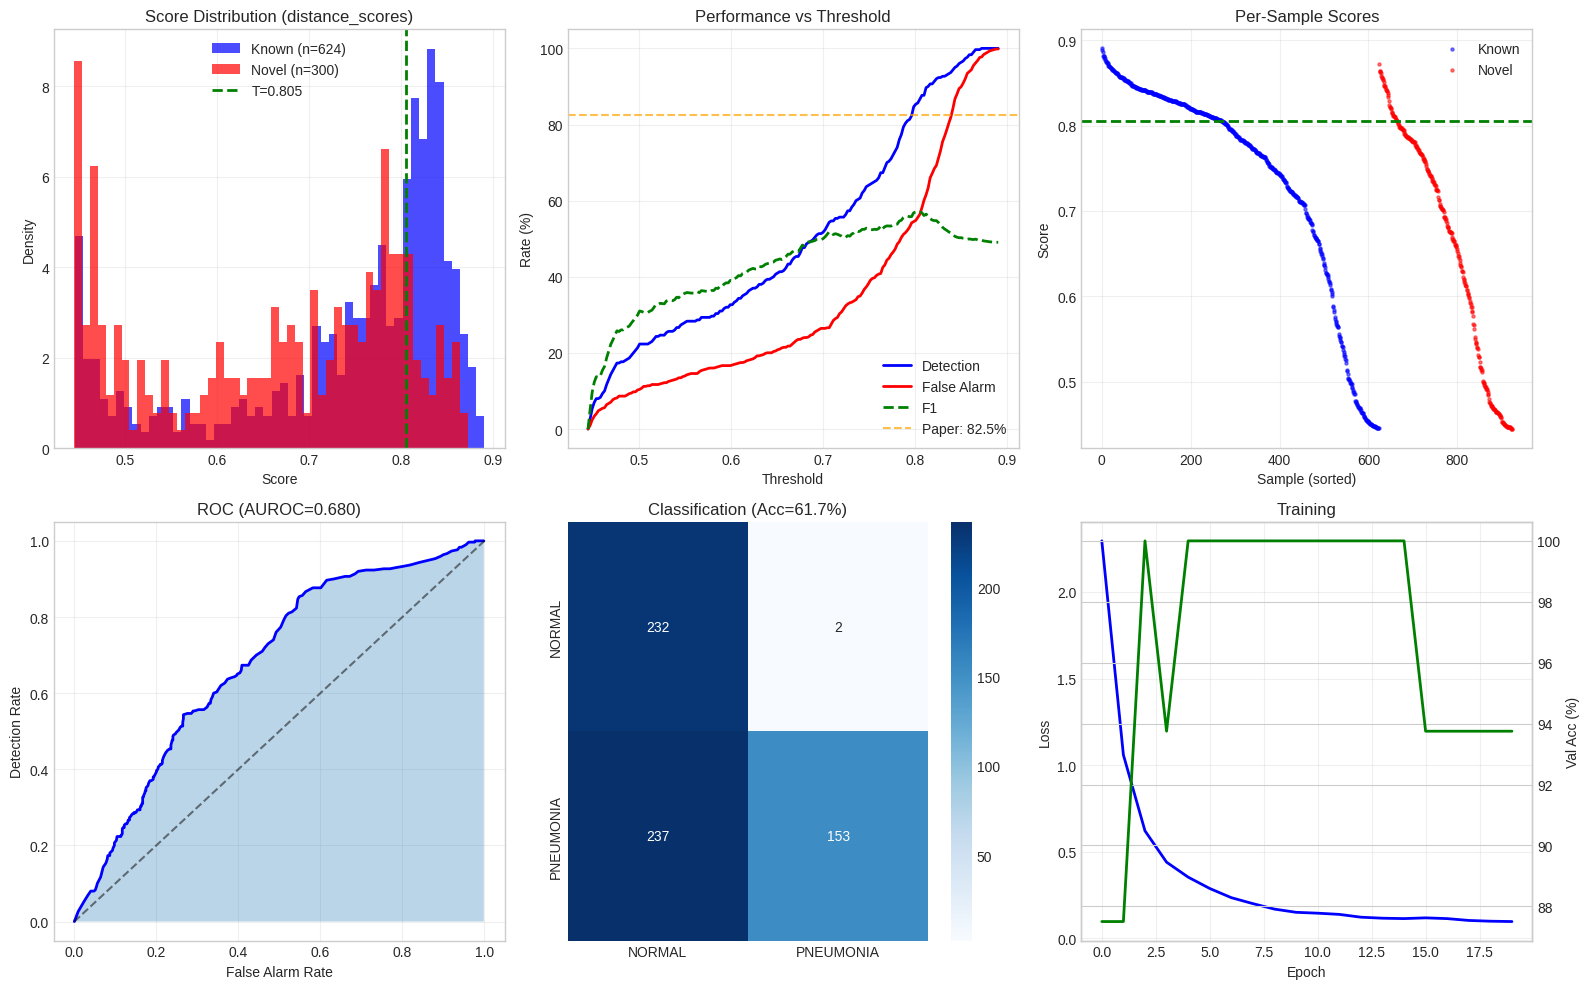


FINAL SUMMARY
Classification Accuracy: 61.70%
Novel Detection Rate:    86.67%
False Alarm Rate:        56.41%
AUROC:                   0.6797
Best Score Type:         distance_scores


In [1]:
import os
import random
import pickle
import warnings
from pathlib import Path
from dataclasses import dataclass
from typing import Tuple, List

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


base_input = Path("/kaggle/input")
CHEST_XRAY_PATH = base_input / "chest-xray-pneumonia/chest_xray"
COVID_PATH = base_input / "covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images"

covid_images = list(COVID_PATH.glob("*.png"))
print(f"Found {len(covid_images)} COVID images at {COVID_PATH}")


@dataclass
class Config:
    chest_xray_dir: str = str(CHEST_XRAY_PATH)
    covid_images: List = None
    output_dir: str = "/kaggle/working/outputs"
    
    known_classes: Tuple[str, ...] = ("NORMAL", "PNEUMONIA")
    
    img_size: int = 224
    feature_dim: int = 512
    batch_size: int = 32
    num_epochs: int = 20
    learning_rate: float = 5e-5
    patience: int = 6
    
    theta: float = 0.30
    gamma: float = 4.0
    min_samples_per_hb: int = 3

config = Config()
config.covid_images = covid_images[:300]
os.makedirs(config.output_dir, exist_ok=True)


class ChestXRayDataset(Dataset):
    def __init__(self, config, split='train', include_novel=False, transform=None):
        self.transform = transform
        self.samples = []
        self.class_to_idx = {c: i for i, c in enumerate(config.known_classes)}
        
        split_path = Path(config.chest_xray_dir) / split
        
        for class_name in config.known_classes:
            class_dir = split_path / class_name
            if not class_dir.exists():
                continue
            images = list(class_dir.glob("*.jpeg")) + list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png"))
            for img_path in images:
                self.samples.append({
                    'path': str(img_path),
                    'label': self.class_to_idx[class_name],
                    'class_name': class_name,
                    'is_novel': False
                })
        
        if include_novel and config.covid_images:
            for img_path in config.covid_images:
                self.samples.append({
                    'path': str(img_path),
                    'label': -1,
                    'class_name': 'COVID',
                    'is_novel': True
                })
        
        known = sum(1 for s in self.samples if not s['is_novel'])
        novel = sum(1 for s in self.samples if s['is_novel'])
        print(f"{split.upper()}: {known} known + {novel} novel = {len(self.samples)}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = Image.open(sample['path']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, sample['label'], sample['is_novel']


def get_transforms(img_size, training=True):
    if training:
        return T.Compose([
            T.Resize((img_size, img_size)),
            T.RandomHorizontalFlip(),
            T.RandomRotation(15),
            T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            T.ColorJitter(brightness=0.3, contrast=0.3),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    return T.Compose([
        T.Resize((img_size, img_size)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


print("\nLoading datasets...")
train_dataset = ChestXRayDataset(config, 'train', include_novel=False, transform=get_transforms(config.img_size, True))
val_dataset = ChestXRayDataset(config, 'val', include_novel=False, transform=get_transforms(config.img_size, False))
test_dataset = ChestXRayDataset(config, 'test', include_novel=True, transform=get_transforms(config.img_size, False))

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)


class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        b, c, _, _ = x.size()
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        max_out = self.fc(self.max_pool(x).view(b, c))
        return x * self.sigmoid(avg_out + max_out).view(b, c, 1, 1)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        return x * self.sigmoid(self.conv(torch.cat([avg_out, max_out], dim=1)))


class AttentionFeatureExtractor(nn.Module):
    def __init__(self, feature_dim=512, dropout=0.4):
        super().__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.features = vgg.features
        
        self.channel_attn = ChannelAttention(512)
        self.spatial_attn = SpatialAttention()
        
        self.pool = nn.AdaptiveAvgPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(512, feature_dim),
            nn.BatchNorm1d(feature_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(feature_dim, feature_dim),
            nn.BatchNorm1d(feature_dim)
        )
        
        for i, param in enumerate(self.features.parameters()):
            param.requires_grad = (i >= 24)
    
    def forward(self, x):
        x = self.features(x)
        x = self.channel_attn(x)
        x = self.spatial_attn(x)
        x = self.pool(x).flatten(1)
        x = self.fc(x)
        return F.normalize(x, p=2, dim=1)


@dataclass
class Hyperbox:
    v: np.ndarray
    w: np.ndarray
    class_label: int
    count: int = 1


class ImprovedFuzzyClassifier:
    def __init__(self, theta=0.3, gamma=4.0, min_samples=3):
        self.theta = theta
        self.gamma = gamma
        self.min_samples = min_samples
        self.hyperboxes = []
        self.classes = set()
        self.class_centroids = {}
        self.class_radii = {}
    
    def membership(self, x, hb):
        result = 1.0
        for i in range(len(x)):
            if x[i] > hb.w[i]:
                val = 1 - self.gamma * (x[i] - hb.w[i])
            elif x[i] < hb.v[i]:
                val = 1 - self.gamma * (hb.v[i] - x[i])
            else:
                val = 1.0
            result = min(result, max(0, val))
            if result == 0:
                break
        return result
    
    def can_expand(self, hb, x):
        new_v = np.minimum(hb.v, x)
        new_w = np.maximum(hb.w, x)
        size = np.sum(new_w - new_v) / len(x)
        return size <= self.theta
    
    def fit(self, X, y):
        indices = np.random.permutation(len(X))
        X, y = X[indices], y[indices]
        
        for label in np.unique(y):
            self.classes.add(label)
            class_data = X[y == label]
            self.class_centroids[label] = class_data.mean(axis=0)
            distances = np.linalg.norm(class_data - self.class_centroids[label], axis=1)
            self.class_radii[label] = np.percentile(distances, 95)
        
        for i in tqdm(range(len(X)), desc="Training Fuzzy Classifier"):
            x, label = X[i], y[i]
            
            best_hb, best_mem = None, -1
            for hb in self.hyperboxes:
                if hb.class_label == label and self.can_expand(hb, x):
                    mem = self.membership(x, hb)
                    if mem > best_mem:
                        best_mem, best_hb = mem, hb
            
            if best_hb and best_mem > 0.5:
                best_hb.v = np.minimum(best_hb.v, x)
                best_hb.w = np.maximum(best_hb.w, x)
                best_hb.count += 1
            else:
                self.hyperboxes.append(Hyperbox(x.copy(), x.copy(), label, 1))
        
        self.hyperboxes = [hb for hb in self.hyperboxes if hb.count >= self.min_samples]
        
        for c in self.classes:
            n_hb = sum(1 for hb in self.hyperboxes if hb.class_label == c)
            print(f"  Class {c}: {n_hb} hyperboxes")
        print(f"  Total: {len(self.hyperboxes)} hyperboxes")
    
    def compute_scores(self, x):
        class_mems = {c: 0.0 for c in self.classes}
        for hb in self.hyperboxes:
            mem = self.membership(x, hb)
            class_mems[hb.class_label] = max(class_mems[hb.class_label], mem)
        
        max_mem = max(class_mems.values()) if class_mems else 0.0
        pred = max(class_mems, key=class_mems.get) if class_mems else -1
        
        min_dist_ratio = float('inf')
        for c in self.classes:
            dist = np.linalg.norm(x - self.class_centroids[c])
            ratio = dist / (self.class_radii[c] + 1e-8)
            min_dist_ratio = min(min_dist_ratio, ratio)
        
        dist_score = 1.0 / (1.0 + min_dist_ratio)
        
        combined = 0.6 * max_mem + 0.4 * dist_score
        
        return {
            'membership': max_mem,
            'distance_score': dist_score,
            'combined': combined,
            'prediction': pred
        }


class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim):
        super().__init__()
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))
    
    def forward(self, x, labels):
        centers_batch = self.centers[labels]
        return ((x - centers_batch) ** 2).sum() / (2 * x.size(0))


class AttentionFuzzyNet:
    def __init__(self, config):
        self.config = config
        self.feature_extractor = AttentionFeatureExtractor(config.feature_dim).to(DEVICE)
        self.classifier_head = None
        self.center_loss = None
        self.fuzzy_classifier = None
        self.scaler = StandardScaler()
        self.history = {'loss': [], 'val_acc': []}
    
    def extract_features(self, loader, desc="Extracting"):
        self.feature_extractor.eval()
        features, labels, novels = [], [], []
        
        with torch.no_grad():
            for imgs, lbls, nvls in tqdm(loader, desc=desc):
                feats = self.feature_extractor(imgs.to(DEVICE))
                features.append(feats.cpu().numpy())
                labels.extend(lbls.numpy())
                novels.extend([bool(n) for n in nvls])
        
        return np.vstack(features), np.array(labels), np.array(novels, dtype=bool)
    
    def train(self, train_loader, val_loader):
        print("\n" + "="*70)
        print("PHASE 1: TRAINING FEATURE EXTRACTOR WITH CENTER LOSS")
        print("="*70)
        
        n_classes = len(self.config.known_classes)
        self.classifier_head = nn.Linear(self.config.feature_dim, n_classes).to(DEVICE)
        self.center_loss = CenterLoss(n_classes, self.config.feature_dim).to(DEVICE)
        
        params = list(self.feature_extractor.parameters()) + list(self.classifier_head.parameters())
        optimizer = torch.optim.AdamW(params, lr=self.config.learning_rate, weight_decay=1e-4)
        center_optimizer = torch.optim.SGD(self.center_loss.parameters(), lr=0.5)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
        criterion = nn.CrossEntropyLoss()
        
        best_acc, patience = 0.0, 0
        
        for epoch in range(self.config.num_epochs):
            self.feature_extractor.train()
            self.classifier_head.train()
            total_loss = 0.0
            
            for imgs, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
                valid = labels >= 0
                if valid.sum() == 0:
                    continue
                
                imgs, labels = imgs[valid].to(DEVICE), labels[valid].to(DEVICE)
                
                optimizer.zero_grad()
                center_optimizer.zero_grad()
                
                features = self.feature_extractor(imgs)
                outputs = self.classifier_head(features)
                
                ce_loss = criterion(outputs, labels)
                c_loss = self.center_loss(features, labels) * 0.01
                loss = ce_loss + c_loss
                
                loss.backward()
                optimizer.step()
                center_optimizer.step()
                
                total_loss += loss.item()
            
            val_acc = self._validate(val_loader)
            self.history['loss'].append(total_loss / len(train_loader))
            self.history['val_acc'].append(val_acc)
            
            print(f"Epoch {epoch+1}: Loss={total_loss/len(train_loader):.4f}, Val Acc={val_acc:.2f}%")
            
            if val_acc >= best_acc:
                best_acc = val_acc
                patience = 0
                torch.save(self.feature_extractor.state_dict(), f"{self.config.output_dir}/best.pth")
            else:
                patience += 1
                if patience >= self.config.patience:
                    print("Early stopping")
                    break
            
            scheduler.step()
        
        self.feature_extractor.load_state_dict(torch.load(f"{self.config.output_dir}/best.pth"))
        print(f"Best validation accuracy: {best_acc:.2f}%")
        
        print("\n" + "="*70)
        print("PHASE 2: TRAINING FUZZY CLASSIFIER")
        print("="*70)
        
        features, labels, _ = self.extract_features(train_loader, "Extracting training features")
        valid = labels >= 0
        features_valid = features[valid]
        labels_valid = labels[valid]
        
        features_scaled = self.scaler.fit_transform(features_valid)
        
        self.fuzzy_classifier = ImprovedFuzzyClassifier(
            theta=self.config.theta,
            gamma=self.config.gamma,
            min_samples=self.config.min_samples_per_hb
        )
        self.fuzzy_classifier.fit(features_scaled, labels_valid)
    
    def _validate(self, loader):
        self.feature_extractor.eval()
        self.classifier_head.eval()
        correct, total = 0, 0
        
        with torch.no_grad():
            for imgs, labels, _ in loader:
                valid = labels >= 0
                if valid.sum() == 0:
                    continue
                imgs, labels = imgs[valid].to(DEVICE), labels[valid].to(DEVICE)
                preds = self.classifier_head(self.feature_extractor(imgs)).argmax(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        return 100 * correct / total if total > 0 else 0
    
    def evaluate(self, loader):
        print("\n" + "="*70)
        print("PHASE 3: EVALUATION")
        print("="*70)
        
        features, labels, novels = self.extract_features(loader, "Extracting test features")
        features_scaled = self.scaler.transform(features)
        
        print(f"\nTest: {(~novels).sum()} known, {novels.sum()} novel")
        
        all_scores = []
        predictions = []
        
        for x in tqdm(features_scaled, desc="Computing scores"):
            scores = self.fuzzy_classifier.compute_scores(x)
            all_scores.append(scores)
            predictions.append(scores['prediction'])
        
        memberships = np.array([s['membership'] for s in all_scores])
        distance_scores = np.array([s['distance_score'] for s in all_scores])
        combined_scores = np.array([s['combined'] for s in all_scores])
        predictions = np.array(predictions)
        
        return {
            'memberships': memberships,
            'distance_scores': distance_scores,
            'combined': combined_scores,
            'predictions': predictions,
            'labels': labels,
            'novels': novels
        }


print("\n" + "="*70)
print("TRAINING ATTENTIONFUZZYNET")
print("="*70)

model = AttentionFuzzyNet(config)
model.train(train_loader, val_loader)

results = model.evaluate(test_loader)

novels = results['novels']
labels = results['labels']
predictions = results['predictions']
known_mask = ~novels
novel_mask = novels

print("\n" + "="*70)
print("SCORE ANALYSIS")
print("="*70)

score_types = ['memberships', 'distance_scores', 'combined']
best_overall = {'score_type': None, 'auroc': 0, 'detection': 0, 'fa': 0, 'threshold': 0, 'f1': 0}

for score_type in score_types:
    scores = results[score_type]
    known_scores = scores[known_mask]
    novel_scores = scores[novel_mask]
    
    sep = known_scores.mean() - novel_scores.mean()
    
    print(f"\n{score_type.upper()}:")
    print(f"  Known: mean={known_scores.mean():.4f}, std={known_scores.std():.4f}")
    print(f"  Novel: mean={novel_scores.mean():.4f}, std={novel_scores.std():.4f}")
    print(f"  Separation: {sep:.4f} {'(GOOD)' if sep > 0.05 else '(POOR)'}")
    
    try:
        auroc = roc_auc_score(novels.astype(int), -scores)
        print(f"  AUROC: {auroc:.4f}")
    except:
        auroc = 0.5
    
    thresholds = np.linspace(scores.min(), scores.max(), 200)
    best_for_type = {'f1': 0}
    
    for T in thresholds:
        novel_pred = scores < T
        tp = (novels & novel_pred).sum()
        fp = (~novels & novel_pred).sum()
        tn = (~novels & ~novel_pred).sum()
        fn = (novels & ~novel_pred).sum()
        
        det = tp / (tp + fn) if (tp + fn) > 0 else 0
        fa = fp / (fp + tn) if (fp + tn) > 0 else 0
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * prec * det / (prec + det) if (prec + det) > 0 else 0
        
        if f1 > best_for_type['f1']:
            best_for_type = {'T': T, 'det': det, 'fa': fa, 'f1': f1, 'auroc': auroc}
    
    print(f"  Best: Det={best_for_type['det']*100:.1f}%, FA={best_for_type['fa']*100:.1f}%, F1={best_for_type['f1']*100:.1f}%")
    
    if auroc > best_overall['auroc']:
        best_overall = {
            'score_type': score_type,
            'auroc': auroc,
            'detection': best_for_type['det'],
            'fa': best_for_type['fa'],
            'threshold': best_for_type['T'],
            'f1': best_for_type['f1']
        }

print("\n" + "="*70)
print(f"BEST SCORE TYPE: {best_overall['score_type'].upper()}")
print("="*70)

best_scores = results[best_overall['score_type']]
known_scores = best_scores[known_mask]
novel_scores = best_scores[novel_mask]

y_true = labels[known_mask]
y_pred = predictions[known_mask]
valid = y_pred >= 0
class_acc = accuracy_score(y_true[valid], y_pred[valid]) if valid.sum() > 0 else 0
class_f1 = f1_score(y_true[valid], y_pred[valid], average='weighted') if valid.sum() > 0 else 0

print(f"\nClassification (Known):")
print(f"  Accuracy: {class_acc*100:.2f}%")
print(f"  F1: {class_f1*100:.2f}%")

print(f"\nNovel Detection:")
print(f"  Detection Rate: {best_overall['detection']*100:.2f}%")
print(f"  False Alarm:    {best_overall['fa']*100:.2f}%")
print(f"  AUROC:          {best_overall['auroc']:.4f}")
print(f"  F1:             {best_overall['f1']*100:.2f}%")

thresholds = np.linspace(best_scores.min(), best_scores.max(), 200)
det_rates, fa_rates, f1_scores = [], [], []

for T in thresholds:
    novel_pred = best_scores < T
    tp = (novels & novel_pred).sum()
    fp = (~novels & novel_pred).sum()
    tn = (~novels & ~novel_pred).sum()
    fn = (novels & ~novel_pred).sum()
    
    det = tp / (tp + fn) if (tp + fn) > 0 else 0
    fa = fp / (fp + tn) if (fp + tn) > 0 else 0
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * prec * det / (prec + det) if (prec + det) > 0 else 0
    
    det_rates.append(det)
    fa_rates.append(fa)
    f1_scores.append(f1)

print("\nPerformance at Detection Targets:")
for target in [0.60, 0.70, 0.80, 0.90]:
    for i, det in enumerate(det_rates):
        if det >= target:
            print(f"  {target*100:.0f}%: Det={det*100:.1f}%, FA={fa_rates[i]*100:.1f}%")
            break

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

axes[0,0].hist(known_scores, bins=50, alpha=0.7, label=f'Known (n={len(known_scores)})', color='blue', density=True)
axes[0,0].hist(novel_scores, bins=50, alpha=0.7, label=f'Novel (n={len(novel_scores)})', color='red', density=True)
axes[0,0].axvline(best_overall['threshold'], color='green', ls='--', lw=2, label=f"T={best_overall['threshold']:.3f}")
axes[0,0].set_xlabel('Score')
axes[0,0].set_ylabel('Density')
axes[0,0].set_title(f"Score Distribution ({best_overall['score_type']})")
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

axes[0,1].plot(thresholds, [d*100 for d in det_rates], 'b-', lw=2, label='Detection')
axes[0,1].plot(thresholds, [f*100 for f in fa_rates], 'r-', lw=2, label='False Alarm')
axes[0,1].plot(thresholds, [f*100 for f in f1_scores], 'g--', lw=2, label='F1')
axes[0,1].axhline(82.5, color='orange', ls='--', alpha=0.7, label='Paper: 82.5%')
axes[0,1].set_xlabel('Threshold')
axes[0,1].set_ylabel('Rate (%)')
axes[0,1].set_title('Performance vs Threshold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

axes[0,2].scatter(range(len(known_scores)), np.sort(known_scores)[::-1], c='blue', s=5, alpha=0.5, label='Known')
axes[0,2].scatter(range(len(known_scores), len(known_scores)+len(novel_scores)), np.sort(novel_scores)[::-1], c='red', s=5, alpha=0.5, label='Novel')
axes[0,2].axhline(best_overall['threshold'], color='green', ls='--', lw=2)
axes[0,2].set_xlabel('Sample (sorted)')
axes[0,2].set_ylabel('Score')
axes[0,2].set_title('Per-Sample Scores')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

sorted_pairs = sorted(zip(fa_rates, det_rates))
fa_sorted, det_sorted = zip(*sorted_pairs)
axes[1,0].plot(fa_sorted, det_sorted, 'b-', lw=2)
axes[1,0].fill_between(fa_sorted, det_sorted, alpha=0.3)
axes[1,0].plot([0,1], [0,1], 'k--', alpha=0.5)
axes[1,0].set_xlabel('False Alarm Rate')
axes[1,0].set_ylabel('Detection Rate')
axes[1,0].set_title(f"ROC (AUROC={best_overall['auroc']:.3f})")
axes[1,0].grid(True, alpha=0.3)

if valid.sum() > 0:
    cm = confusion_matrix(y_true[valid], y_pred[valid])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,1],
                xticklabels=config.known_classes, yticklabels=config.known_classes)
    axes[1,1].set_title(f'Classification (Acc={class_acc*100:.1f}%)')

axes[1,2].plot(model.history['loss'], 'b-', lw=2)
axes[1,2].set_xlabel('Epoch')
axes[1,2].set_ylabel('Loss')
ax2 = axes[1,2].twinx()
ax2.plot(model.history['val_acc'], 'g-', lw=2)
ax2.set_ylabel('Val Acc (%)')
axes[1,2].set_title('Training')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{config.output_dir}/results.png", dpi=150)
plt.show()

print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"Classification Accuracy: {class_acc*100:.2f}%")
print(f"Novel Detection Rate:    {best_overall['detection']*100:.2f}%")
print(f"False Alarm Rate:        {best_overall['fa']*100:.2f}%")
print(f"AUROC:                   {best_overall['auroc']:.4f}")
print(f"Best Score Type:         {best_overall['score_type']}")
print("="*70)